<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B1%5D_ODE_PINN_ClassForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Credits : Mahmoud Asem @Asem000  July 2022

In [ ]:
!pip install optax
!pip install pytreeclass # for PyTorch like API
!pip install tqdm

In [2]:
#Imports
from typing import List , Callable
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

import optax
from pytreeclass import treeclass,tree_viz
import sympy as sp
import functools
from tqdm.notebook import tqdm

### Generate a a differential equation and its solution using SymPy

In [3]:
t= sp.symbols('t')
f = sp.Function('y')
diffeq = sp.Eq(f(t).diff(t,t) + f(t).diff(t)-t*sp.cos(2*sp.pi*t),0)
sol = sp.simplify(sp.dsolve(diffeq,ics={f(0):1,f(t).diff(t).subs(t,0):10}).rhs)

In [4]:
diffeq

Eq(-t*cos(2*pi*t) + Derivative(y(t), t) + Derivative(y(t), (t, 2)), 0)

In [5]:
sp.Eq(f(t).diff(t).subs(t,0),10)

Eq(Subs(Derivative(y(t), t), t, 0), 10)

In [6]:
sp.Eq(f(t).subs(t,0),1)

Eq(y(0), 1)

In [14]:
sp.Eq(f(t),sol)

Eq(y(t), (2*pi*t*exp(t)*sin(2*pi*t) + 8*pi**3*t*exp(t)*sin(2*pi*t) - 16*pi**4*t*exp(t)*cos(2*pi*t) - 4*pi**2*t*exp(t)*cos(2*pi*t) + 16*pi**3*exp(t)*sin(2*pi*t) + exp(t)*cos(2*pi*t) + 12*pi**2*exp(t)*cos(2*pi*t) - exp(t) + 36*pi**2*exp(t) + 336*pi**4*exp(t) + 704*pi**6*exp(t) - 640*pi**6 - 304*pi**4 - 44*pi**2)*exp(-t)/(4*pi**2*(1 + 8*pi**2 + 16*pi**4)))

In [15]:
#verify solution
sp.simplify(-t*sp.cos(sp.pi*2*t)+sol.diff(t)+sol.diff(t,t))

0

### Constructing the MLP

In [16]:
N_b = 1
N_c = 100

tmin,tmax=0. ,jnp.pi

'''boundary conditions'''


# U[0] = 1
t_0 = jnp.ones([N_b,1],dtype='float32')*0.
ic_0 = jnp.ones_like(t_0) 
IC_0 = jnp.concatenate([t_0,ic_0],axis=1)

# U_t[0] = 10
t_b1 = jnp.zeros([N_b,1])
bc_1 = jnp.ones_like(t_b1) * 10
BC_1 = jnp.concatenate([t_b1,bc_1],axis=1)

conds = [IC_0,BC_1]

#collocation points

key=jax.random.PRNGKey(0)

t_c = jax.random.uniform(key,minval=tmin,maxval=tmax,shape=(N_c,1))
colloc = t_c


# Build Model

In [21]:
@treeclass
class Linear :
    weight : jnp.ndarray
    bias   : jnp.ndarray

    def __init__(self,key,in_dim,out_dim):
        self.weight = jax.random.normal(key,shape=(in_dim, out_dim)) * jnp.sqrt(2/in_dim)
        self.bias = jnp.ones((1,out_dim))

    def __call__(self,x):
        return x @ self.weight + self.bias


@treeclass
class MLP :
    l1 : Linear
    l2 : Linear
    l3 : Linear 
    l4 : Linear

    def __init__(self,key=jax.random.PRNGKey(0)):
        k1,k2,k3,k4 = jax.random.split(key,4)

        self.l1 = Linear(k1,1,20)
        self.l2 = Linear(k2,20,20)
        self.l3 = Linear(k3,20,20)
        self.l4 = Linear(k4,20,1)
        
    def __call__(self,x):
        x = self.l1(x)
        x = jax.nn.tanh(x)
        x = self.l2(x)
        x = jax.nn.tanh(x)
        x = self.l3(x)
        x = jax.nn.tanh(x)
        x = self.l4(x)
        return x

model = MLP()
print(f"{model!r}")
print(model.tree_diagram())
print(model.summary())
print(model.tree_box(array=colloc))


MLP(
  l1=Linear(weight=f32[1,20],bias=f32[1,20]),
  l2=Linear(weight=f32[20,20],bias=f32[1,20]),
  l3=Linear(weight=f32[20,20],bias=f32[1,20]),
  l4=Linear(weight=f32[20,1],bias=f32[1,1])
)
MLP
    ├── l1=Linear
    │   ├── weight=f32[1,20]
    │   └── bias=f32[1,20]  
    ├── l2=Linear
    │   ├── weight=f32[20,20]
    │   └── bias=f32[1,20]  
    ├── l3=Linear
    │   ├── weight=f32[20,20]
    │   └── bias=f32[1,20]  
    └── l4=Linear
        ├── weight=f32[20,1]
        └── bias=f32[1,1]       
┌────┬──────┬───────┬───────┬─────────────────┐
│Name│Type  │Param #│Size   │Config           │
├────┼──────┼───────┼───────┼─────────────────┤
│l1  │Linear│40(0)  │160.00B│weight=f32[1,20] │
│    │      │       │(0.00B)│bias=f32[1,20]   │
├────┼──────┼───────┼───────┼─────────────────┤
│l2  │Linear│420(0) │1.64KB │weight=f32[20,20]│
│    │      │       │(0.00B)│bias=f32[1,20]   │
├────┼──────┼───────┼───────┼─────────────────┤
│l3  │Linear│420(0) │1.64KB │weight=f32[20,20]│
│    │      │  

In [25]:
@jax.jit
def MSE(true,pred):
    return jnp.mean((true-pred)**2)

def diff(func:Callable,*args,**kwargs):
  """sum then grad"""
  return jax.grad(lambda *ar,**kws: jnp.sum(func(*ar,**kws)), *args, **kwargs)

def loss_func(model,colloc,conds):
    t_c =colloc[:,[0]]
    ufunc = model
    ufunc_t = diff(model)
        
    loss =jnp.mean(ODE_loss(t_c,ufunc) **2)

    t_ic,u_ic = conds[0][:,[0]],conds[0][:,[1]]  
    loss += MSE(u_ic,ufunc(t_ic))

    t_bc,u_bc = conds[1][:,[0]],conds[1][:,[1]]  
    loss += MSE(u_bc,ufunc_t(t_bc))

    return  loss

def ODE_loss(t,u):
    u_t = diff(u)
    u_tt = diff(u_t)
    return -t*jnp.cos(2*jnp.pi*t) + u_t(t) + u_tt(t)

@jax.jit
def update(opt_state,model,colloc,conds):
    # Get the gradient w.r.t to MLP params
    grads= jax.grad(loss_func)(model,colloc,conds)
    
    #Update model
    updates, opt_state = optimizer.update(grads, opt_state)
    model = optax.apply_updates(model, updates)

    return opt_state,model


In [23]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(model)

In [ ]:
%%time
epochs = 10_000
for _ in tqdm(range(1,epochs+1)):
  opt_state,model = update(opt_state,model,colloc,conds)

  # print loss and epoch info
  if _ %(100) ==0:
    print(f'Epoch={_}\tloss={loss_func(model,colloc,conds):.3e}')

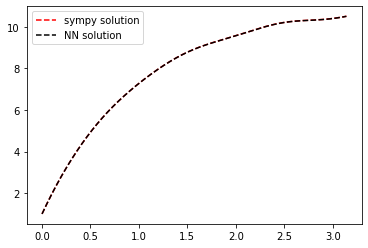

In [27]:
lam_sol= sp.lambdify(t,sol)

dT = 1e-3
Tf = jnp.pi
T = np.arange(0,Tf+dT,dT)


sym_sol =np.array([lam_sol(i) for i in T])
z
plt.plot(T,sym_sol,'--r',label='sympy solution')
plt.plot(T,model(T.reshape(-1,1))[:,0],'--k',label='NN solution')
plt.legend()